# Visualization of PASEOS

### First load the necessary packages

In [ ]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../..")

import paseos
from paseos import SpaceAnimation
from paseos.actors.spacecraft_actor import SpacecraftActor
from paseos.actors.actor_builder import ActorBuilder
import pykep as pk

### Create a PASEOS object. Add a local actor as satellite 1 and a known actor as satellite 2.

In [2]:
 # Define central body
earth = pk.planet.jpl_lp("earth")

# Define local actor
sat1 = ActorBuilder.get_actor_scaffold(
    "sat1", SpacecraftActor, [10000000, 0, 0], pk.epoch(0)
)
ActorBuilder.set_orbit(sat1, [10000000, 0, 0], [0, 8000.0, 0], pk.epoch(0), earth)
ActorBuilder.set_power_devices(sat1, 500, 10000, 1)

# init simulation
sim = paseos.init_sim(sat1)

sat2 = ActorBuilder.get_actor_scaffold(
        "sat2", SpacecraftActor, [10000000, 0, 0], pk.epoch(0)
    )
ActorBuilder.set_orbit(sat2, [0, 10000000, 0], [0, 0, 8000.0], pk.epoch(0), earth)
sim.add_known_actor(sat2)


14:36:16|PASEOS-DEBUG| Added orbit to actor sat1
14:36:16|PASEOS-DEBUG| Added power device. MaxBattery=10000Ws, CurrBattery=500Ws, ChargingRate=1W to actor sat1
14:36:16|PASEOS-DEBUG| Initializing simulation.
14:36:16|PASEOS-DEBUG| Loading default cfg...
14:36:16|PASEOS-DEBUG| Added orbit to actor sat2
14:36:16|PASEOS-DEBUG| Adding actor:sat2
14:36:16|PASEOS-DEBUG| Current actors: dict_keys([])


### Step the simulation in time and visualize the actors.

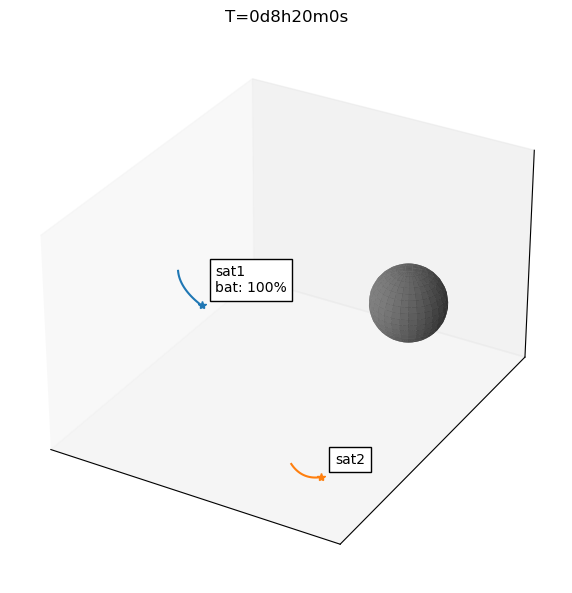

In [3]:
from IPython import display
from loguru import logger
import time 

logger.remove() 
logger.add(sys.stderr, level="INFO")# using DEBUG level will create tons of text

anim = SpaceAnimation(sim)

dt = 100  # time step in seconds
for x in range(100):
    anim.animate(sim, dt)
    display.display(anim.fig) 
    time.sleep(0.01)
    display.clear_output(wait =True)
